# Mini Project : Deep Learning (Machine Learning GDGoC Universitas Sriwijaya)

- Muhammad Aditya Bayhaqie
- Nabila Nurhusna Yap

Objective :

> Build a deep learning model to solve a problem either in image classification, text classification, or sequence prediction.

## CNN Model

### Library Preparation

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

### Data Wrangling

#### Data Collection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 96% 705M/736M [00:03<00:00, 161MB/s]
100% 736M/736M [00:03<00:00, 206MB/s]


In [ ]:
!unzip eye-diseases-classification.zip

Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_l

#### Data Assessment

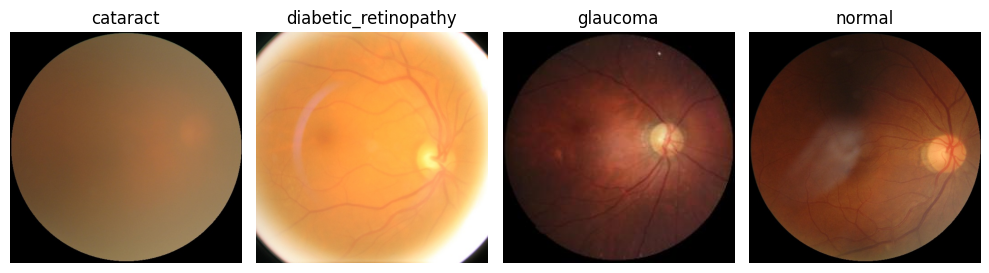

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def display_images_by_label(data_dir):
    labels = os.listdir(data_dir)
    labels.sort() # Sort labels for consistent display

    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes = axes.ravel()

    # Limit to the number of subplots available
    num_subplots = len(axes)
    for i, label in enumerate(labels[:num_subplots]):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            if image_files:
                # Select a random image from the label directory
                random_image_file = random.choice(image_files)
                img_path = os.path.join(label_path, random_image_file)
                img = mpimg.imread(img_path)

                axes[i].imshow(img)
                axes[i].set_title(label)
                axes[i].axis('off') # Hide axes

    # Hide any unused subplots if there are less than the number of subplots
    for j in range(len(labels), num_subplots):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming the unzipped data is in a directory named 'dataset'
# Adjust the path according to where your unzipped data is located
data_directory = 'dataset'
display_images_by_label(data_directory)

#### Data Engineering

In [ ]:
# Define the original data directory and the new train/val directories
data_directory = 'dataset'
train_dir = 'train'
val_dir = 'val'

# Create the train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get the list of labels (subdirectories)
labels = os.listdir(data_directory)

for label in labels:
    label_path = os.path.join(data_directory, label)
    if os.path.isdir(label_path):
        # Create subdirectories for the label in train and val
        train_label_dir = os.path.join(train_dir, label)
        val_label_dir = os.path.join(val_dir, label)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)

        # Get the list of image files in the current label directory
        image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(image_files) # Shuffle the images

        # Calculate the split point (90% for training)
        split_point = int(len(image_files) * 0.9)

        # Split the images into training and validation sets
        train_files = image_files[:split_point]
        val_files = image_files[split_point:]

        # Copy the files to the respective train and val directories
        for filename in train_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(train_label_dir, filename)
            shutil.copy(src_path, dest_path)

        for filename in val_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(val_label_dir, filename)
            shutil.copy(src_path, dest_path)

print("Data split into train and validation directories (9:1 ratio) successful.")
print(f"Train data saved in: {train_dir}")
print(f"Validation data saved in: {val_dir}")

Data split into train and validation directories (9:1 ratio) successful.
Train data saved in: train
Validation data saved in: val


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x.lower()])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Model Development

### Model Evaluation

## Pre-Build Model

### Library Preparation

### Data Wrangling

#### Data Collection

#### Data Assessment

#### Data Engineering

### Model Development

### Model Evaluation